In [ ]:
import torch
import torchvision
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

from src.data.fingerprint import SVDFingerprintGenerator, FEDS

# Randomly sample local client training dataset

In [2]:
def sample_from_dataset(dataset, samples=500):
    np.random.seed(42)
    indices = np.random.choice(len(dataset), samples, replace=False)
    data = []
    targets = []
    for idx in indices:
        data.append(dataset.data[idx])
        targets.append(dataset.targets[idx])
    #sort by target
    data = np.array(data)

    targets = np.array(targets)
    idx = np.argsort(targets)
    data = data[idx]
    targets = targets[idx]
    
    return np.array(data), np.array(targets)


trn_set = torchvision.datasets.CIFAR100(root='data', train=True, download=True)
sel_data, sel_targ = sample_from_dataset(trn_set, 50)
client_data = FEDS(sel_data, sel_targ)

Files already downloaded and verified


# Calculate PACFL fingerprints based on the local trainin dataset

In [3]:
fpg = SVDFingerprintGenerator(client_data)
fps = fpg.generate_fingerprint()

Calculating SVD for class: 0
Calculating SVD for class: 1
Calculating SVD for class: 2
Calculating SVD for class: 3
Calculating SVD for class: 4
Calculating SVD for class: 5
Calculating SVD for class: 6
Calculating SVD for class: 7
Calculating SVD for class: 8
Calculating SVD for class: 9
Calculating SVD for class: 10
Calculating SVD for class: 11
Calculating SVD for class: 12
Calculating SVD for class: 13
Calculating SVD for class: 14
Calculating SVD for class: 15
Calculating SVD for class: 16
Calculating SVD for class: 17
Calculating SVD for class: 18
Calculating SVD for class: 19
Calculating SVD for class: 20
Calculating SVD for class: 21
Calculating SVD for class: 22
Calculating SVD for class: 23
Calculating SVD for class: 24
Calculating SVD for class: 25
Calculating SVD for class: 26
Calculating SVD for class: 27
Calculating SVD for class: 28
Calculating SVD for class: 29
Calculating SVD for class: 30
Calculating SVD for class: 31
Calculating SVD for class: 32
Calculating SVD for 

# Calculate SSIM between every original training data sample and every fingerprint eigenvector

In [ ]:
ssim_fn = torchmetrics.StructuralSimilarityIndexMeasure()

#ensure that data and fps are between 0 and 1
def scale_01(tensor):
    t = []
    for x in tensor:
        t.append(1 - (x.max()-x) / ((x.max() - x.min())+1e-5))
    return torch.stack(t)

#calculate similarity matrix between all samples in orig and all samples in fps
def calculate_similarity_matrix(orig, fps):
    sim_matrix = np.zeros((orig.shape[0], fps.shape[0]))
    for i in tqdm(range(orig.shape[0])):
        for j in range(fps.shape[0]):
            sim_matrix[i, j] = ssim_fn(orig[i].unsqueeze(0), fps[j].unsqueeze(0))
    return sim_matrix

#reshape and to tensor for SSIM calculation
sel_data = torch.tensor(sel_data/255).permute(0, 3, 1, 2)
scaled_data = scale_01(sel_data)

shaped_fps = torch.tensor(fps).reshape(32, 32, 3, fps.shape[1]).permute(3, 2, 0, 1)
scaled_fps = scale_01(shaped_fps)

# sim_matrix = calculate_similarity_matrix(scaled_data, scaled_fps)
# np.save('demo/CIFAR100_SVD_demo_sim_matrix.npy', sim_matrix)

sim_matrix = np.load('data/demo/CIFAR100_SVD_demo_sim_matrix.npy')

# Find most similar matches

In [5]:
# find the 10 highest values in the matrix and return their indices
def find_highest_indices(sim_matrix, num_highest):
    highest_indices = []
    for i in range(num_highest):
        max_idx = np.unravel_index(np.argmax(sim_matrix, axis=None), sim_matrix.shape)
        highest_indices.append(max_idx)
        sim_matrix[max_idx[0], :] = -1
        sim_matrix[:, max_idx[1]] = -1
    return highest_indices

highest_indices = find_highest_indices(sim_matrix, 10)
highest_indices

[(217, 186),
 (299, 250),
 (183, 156),
 (496, 420),
 (250, 209),
 (295, 245),
 (345, 296),
 (360, 308),
 (430, 365),
 (215, 185)]

In [6]:
# # get those images and save them to numpy array
# highest_images = []
# for idx in highest_indices:
#     highest_images.append(scaled_data[idx[0]])
# highest_images = torch.stack(highest_images)

# highest_fingerprints = []
# for idx in highest_indices:
#     highest_fingerprints.append(scaled_fps[idx[1]])
# highest_fingerprints = torch.stack(highest_fingerprints)

# np.save('demo/CIFAR100_SVD_demo_highest_images.npy', highest_images)
# np.save('demo/CIFAR100_SVD_demo_highest_fingerprints.npy', highest_fingerprints)

highest_images = torch.tensor(np.load('data/demo/CIFAR100_SVD_demo_highest_images.npy'))
highest_fingerprints = torch.tensor(np.load('data/demo/CIFAR100_SVD_demo_highest_fingerprints.npy'))

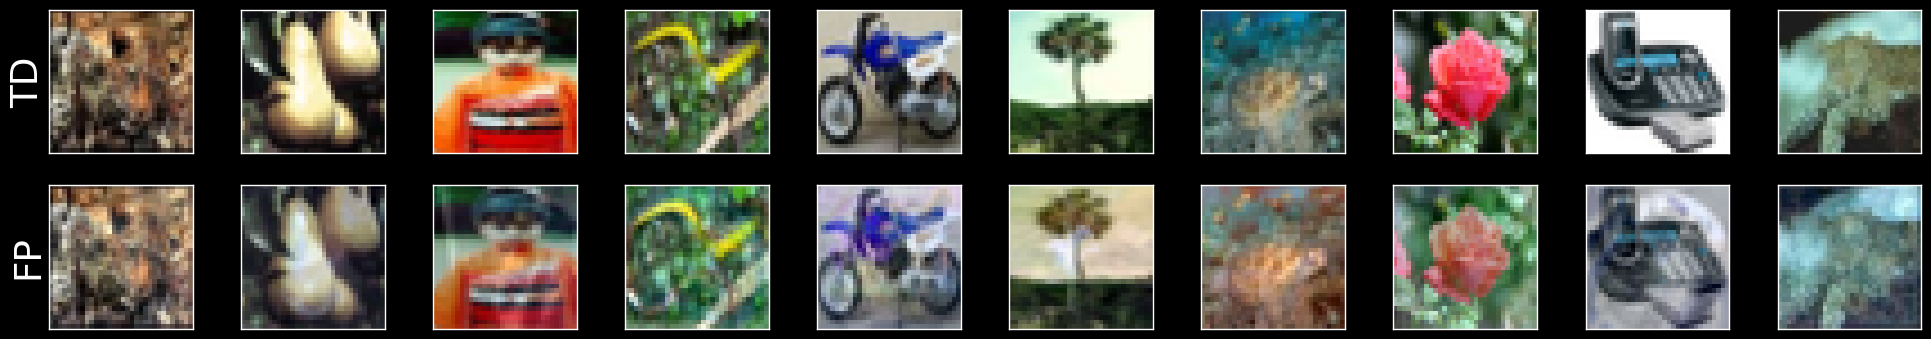

In [7]:
sns.set_context("paper", rc={"text.usetex": True}, font_scale=2.8)

# Show the original and the most similar fingerprint in one plot: top row original, bottom row fingerprint, 10 image columns
fig, ax = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    ax[0, i].imshow(highest_images[i].permute(1, 2, 0))
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    
    fp = highest_fingerprints[i].permute(1, 2, 0)
    # Scale to 0-1
    fp = (fp - fp.min()) / (fp.max() - fp.min())
    ax[1, i].imshow(fp)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

# First row title only on leftmost image (on the y-axis and rotated)
ax[0, 0].set_ylabel('TD', rotation=90, labelpad=15, va='center', ha='center')
# Second row title only on leftmost image (on the y-axis and rotated)
ax[1, 0].set_ylabel('FP', rotation=90, labelpad=15, va='center', ha='center')

plt.tight_layout()

plt.show()